In [2]:
!pip install vaderSentiment

In [3]:
!pip install nltk

In [4]:
!pip install stop_words

In [5]:
pip install punkt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement punkt (from versions: none)
ERROR: No matching distribution found for punkt


# Importing all libraries

In [6]:
import json
import pandas as pd
import numpy as np
import os
import re
import sys
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import stop_words
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gzip
import pickle
import tensorflow as tf

In [8]:
pre_order_df = pd.read_csv('Datasets/Inflight Service_Pre order data.csv')
inventory_df = pd.read_csv('Datasets/Inflight Service_Inventory data.csv')
customer_comments_df = pd.read_csv('Datasets/Survey data _Customer comments.csv')
satisfacton_df = pd.read_csv('Datasets/Survey data_Inflight Satisfaction Score.csv')

In [9]:
customer_comments_df.head(10)

,flight_number,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,ques_verbatim_text,loyalty_program_level,fleet_type_description,fleet_usage,response_group
0,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,There was no salad dressing. The staff informe...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B777-200,Mainline,member
1,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,Not a choice.,0 to 70,Is there anything else you'd like to share abo...,NaN,B777-200,Mainline,non-member
2,1876,FLX,EWX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More variety and bigger snacks.,90+,Is there anything else you'd like to share abo...,non-elite,A320-200,Mainline,member
3,5469,SFX,SEX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,Serving pretzels and cookies in first class wa...,90+,Is there anything else you'd like to share abo...,premier gold,ERJ-175,Express,member
4,281,DEX,ANX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More inflight selections to purchase for full ...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B737-MAX8,Mainline,member
5,1726,SFX,OGX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,Hot food options would be nice.,90+,Is there anything else you'd like to share abo...,NaN,B777-200,Mainline,non-member
6,929,LHX,ORX,2022-09-01,Early & Ontime,Early & Ontime,Atlantic,"Ok, better than most United flights I have bee...",0 to 70,Is there anything else you'd like to share abo...,NaN,B767-300,Mainline,non-member
7,2049,SJX,IAX,2022-09-01,Early & Ontime,Delayed,Latin,"I enjoy illy coffee, but the decaf instant was...",90+,Is there anything else you'd like to share abo...,non-elite,B737-900,Mainline,member
8,884,LHX,EWX,2022-09-02,Early & Ontime,Early & Ontime,Atlantic,I had a seltzer.,90+,Is there anything else you'd like to share abo...,premier 1k,B767-300,Mainline,member
9,1282,OGX,LAX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,I thought a 3rd entree should be offered. no r...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B737-MAX9,Mainline,member


In [10]:
review_df = customer_comments_df[['verbatim_text']]

In [11]:
review_df

,verbatim_text
0,There was no salad dressing. The staff informe...
1,Not a choice.
2,More variety and bigger snacks.
3,Serving pretzels and cookies in first class wa...
4,More inflight selections to purchase for full ...
...,...
9419,tapas box needs better pita chips. the provide...
9420,My flight attendant missed my drink order 2x a...
9421,Mo.
9422,"without a smartphone, not much to eat. we pack..."


# Preprocessing

In [12]:
def preprocessing(review):
    review = review.lower()
    review = re.sub(r"'",'',review)
    review = re.sub('[^\w\s]',' ',review)
    review = re.sub(" \d+", " ",review)
    review = re.sub(" +",' ',review)
    review = review.strip()
    return review

In [13]:
review_df['preprocessed_text'] = review_df['verbatim_text'].apply(preprocessing) 

C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/362758390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['preprocessed_text'] = review_df['verbatim_text'].apply(preprocessing)


In [14]:
review_df.head(10)

,verbatim_text,preprocessed_text
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...
1,Not a choice.,not a choice
2,More variety and bigger snacks.,more variety and bigger snacks
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...
5,Hot food options would be nice.,hot food options would be nice
6,"Ok, better than most United flights I have bee...",ok better than most united flights i have been on
7,"I enjoy illy coffee, but the decaf instant was...",i enjoy illy coffee but the decaf instant was ...
8,I had a seltzer.,i had a seltzer
9,I thought a 3rd entree should be offered. no r...,i thought a rd entree should be offered no rea...


# Tokenize

In [15]:
review_df['tokenise'] = review_df.apply(lambda x: nltk.word_tokenize(x["preprocessed_text"]), axis=1)
review_df.head()

C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/1931340521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['tokenise'] = review_df.apply(lambda x: nltk.word_tokenize(x["preprocessed_text"]), axis=1)


,verbatim_text,preprocessed_text,tokenise
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ..."
1,Not a choice.,not a choice,"[not, a, choice]"
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]"
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c..."
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for..."


In [16]:
analyser = SentimentIntensityAnalyzer()
def get_sentiment_and_score(preprocessed_review):
    sent_score = None
    sent_label = None
    sentiment_score = analyser.polarity_scores(preprocessed_review)
    if sentiment_score['compound'] >= 0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Positive'
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Neutral'
    elif sentiment_score['compound'] <= -0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Negative'
    return sent_label,sent_score

In [17]:
review_df[['sentiment','sentiment score']] = review_df['preprocessed_text'].apply(get_sentiment_and_score).apply(pd.Series)


C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [18]:
review_df.head(10)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ...",Negative,-0.2960
1,Not a choice.,not a choice,"[not, a, choice]",Neutral,0.0000
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]",Neutral,0.0000
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c...",Negative,-0.5413
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for...",Neutral,0.0000
5,Hot food options would be nice.,hot food options would be nice,"[hot, food, options, would, be, nice]",Positive,0.4215
6,"Ok, better than most United flights I have bee...",ok better than most united flights i have been on,"[ok, better, than, most, united, flights, i, h...",Positive,0.8016
7,"I enjoy illy coffee, but the decaf instant was...",i enjoy illy coffee but the decaf instant was ...,"[i, enjoy, illy, coffee, but, the, decaf, inst...",Negative,-0.6271
8,I had a seltzer.,i had a seltzer,"[i, had, a, seltzer]",Neutral,0.0000
9,I thought a 3rd entree should be offered. no r...,i thought a rd entree should be offered no rea...,"[i, thought, a, rd, entree, should, be, offere...",Negative,-0.6486


# Remove stopwords


In [19]:
stop_words = stopwords.words('english')
review_df['remove_stopwords'] = review_df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

review_df.head(15)

C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/1139899198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['remove_stopwords'] = review_df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])


,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ...",Negative,-0.2960,"[salad, dressing, staff, informed, flight, rec..."
1,Not a choice.,not a choice,"[not, a, choice]",Neutral,0.0000,[choice]
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]",Neutral,0.0000,"[variety, bigger, snacks]"
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c...",Negative,-0.5413,"[serving, pretzels, cookies, first, class, ext..."
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for...",Neutral,0.0000,"[inflight, selections, purchase, full, meals]"
5,Hot food options would be nice.,hot food options would be nice,"[hot, food, options, would, be, nice]",Positive,0.4215,"[hot, food, options, would, nice]"
6,"Ok, better than most United flights I have bee...",ok better than most united flights i have been on,"[ok, better, than, most, united, flights, i, h...",Positive,0.8016,"[ok, better, united, flights]"
7,"I enjoy illy coffee, but the decaf instant was...",i enjoy illy coffee but the decaf instant was ...,"[i, enjoy, illy, coffee, but, the, decaf, inst...",Negative,-0.6271,"[enjoy, illy, coffee, decaf, instant, pleasant..."
8,I had a seltzer.,i had a seltzer,"[i, had, a, seltzer]",Neutral,0.0000,[seltzer]
9,I thought a 3rd entree should be offered. no r...,i thought a rd entree should be offered no rea...,"[i, thought, a, rd, entree, should, be, offere...",Negative,-0.6486,"[thought, rd, entree, offered, real, dessert, ..."


# Lemmatize

In [20]:
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words
review_df['lemmatise'] = review_df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])

review_df.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/4204098789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['lemmatise'] = review_df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])


,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ...",Negative,-0.2960,"[salad, dressing, staff, informed, flight, rec...","[salad, dressing, staff, informed, flight, rec..."
1,Not a choice.,not a choice,"[not, a, choice]",Neutral,0.0000,[choice],[choice]
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]",Neutral,0.0000,"[variety, bigger, snacks]","[variety, bigger, snack]"
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c...",Negative,-0.5413,"[serving, pretzels, cookies, first, class, ext...","[serving, pretzel, cooky, first, class, extrem..."
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for...",Neutral,0.0000,"[inflight, selections, purchase, full, meals]","[inflight, selection, purchase, full, meal]"
5,Hot food options would be nice.,hot food options would be nice,"[hot, food, options, would, be, nice]",Positive,0.4215,"[hot, food, options, would, nice]","[hot, food, option, would, nice]"
6,"Ok, better than most United flights I have bee...",ok better than most united flights i have been on,"[ok, better, than, most, united, flights, i, h...",Positive,0.8016,"[ok, better, united, flights]","[ok, better, united, flight]"
7,"I enjoy illy coffee, but the decaf instant was...",i enjoy illy coffee but the decaf instant was ...,"[i, enjoy, illy, coffee, but, the, decaf, inst...",Negative,-0.6271,"[enjoy, illy, coffee, decaf, instant, pleasant...","[enjoy, illy, coffee, decaf, instant, pleasant..."
8,I had a seltzer.,i had a seltzer,"[i, had, a, seltzer]",Neutral,0.0000,[seltzer],[seltzer]
9,I thought a 3rd entree should be offered. no r...,i thought a rd entree should be offered no rea...,"[i, thought, a, rd, entree, should, be, offere...",Negative,-0.6486,"[thought, rd, entree, offered, real, dessert, ...","[thought, rd, entree, offered, real, dessert, ..."


# LDA Model for Identifying Topics

In [21]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
print(vectorizer)
print(vectorizer.dtype)

# join the processed data to be vectorised
vectors = []

for index, row in review_df.iterrows():
    vectors.append(", ".join(row['lemmatise']))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)
print(vectorised.dtype)

CountVectorizer(ngram_range=(2, 2))
<class 'numpy.int64'>
  (0, 30628)	2
  (0, 10456)	1
  (0, 34360)	1
  (0, 18264)	1
  (0, 13747)	1
  (0, 29598)	1
  (0, 10448)	1
  (2, 38401)	1
  (2, 3879)	1
  (3, 32418)	1
  (3, 28123)	1
  (3, 8177)	1
  (3, 13087)	1
  (3, 6888)	1
  (3, 12592)	1
  (3, 10176)	1
  (3, 29450)	1
  (3, 20484)	1
  (3, 36284)	1
  (3, 6067)	1
  (3, 40329)	1
  (3, 15819)	1
  (3, 20606)	1
  (4, 18218)	1
  (4, 31770)	1
  :	:
  (9420, 30027)	1
  (9420, 27369)	1
  (9420, 15455)	1
  (9420, 29334)	1
  (9420, 19198)	1
  (9422, 14302)	1
  (9422, 13327)	1
  (9422, 25096)	1
  (9422, 22693)	1
  (9422, 40111)	1
  (9422, 33185)	1
  (9422, 11012)	1
  (9422, 25961)	1
  (9422, 14158)	1
  (9422, 11371)	1
  (9422, 5113)	1
  (9422, 1886)	1
  (9422, 18028)	1
  (9422, 19637)	1
  (9422, 37278)	1
  (9423, 7314)	1
  (9423, 40249)	1
  (9423, 35782)	1
  (9423, 987)	1
  (9423, 24451)	1
int64


In [22]:
lda_model = LatentDirichletAllocation(n_components = 5, evaluate_every = -1, n_jobs = -1)
lda_output = lda_model.fit_transform(vectorised)

In [23]:
keywords = np.array(vectorizer.get_feature_names_out())

topic_keywords = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords.append(keywords.take(top_keyword_locs))

for i in topic_keywords:
    print(i)

['gluten free' 'would nice' 'business class' 'food beverage' 'free option'
 'snack box' 'pre order' 'first class' 'long flight' 'would liked'
 'complimentary snack' 'ice cream' 'credit card' 'would like'
 'hour flight' 'snack offered' 'quality food' 'bring back' 'white wine'
 'would good' 'food option' 'meal choice' 'beverage served' 'nice get'
 'flight attendant']
['short flight' 'would nice' 'first class' 'hour flight' 'free snack'
 'gluten free' 'flight attendant' 'food beverage' 'small snack'
 'snack like' 'would great' 'snack would' 'credit card' 'business class'
 'better snack' 'pre order' 'beverage service' 'snack offered'
 'flight food' 'ice cream' 'snack option' 'much better'
 'would appreciated' 'chicken dish' 'food option']
['would like' 'flight attendant' 'would nice' 'first class'
 'food beverage' 'credit card' 'gluten free' 'snack box' 'business class'
 'hour flight' 'ice cream' 'snack provided' 'offered snack'
 'option available' 'long flight' 'red wine' 'food snack' 'dr

In [24]:
keywords

array(['10 shot', '100 persent', '1st class', ..., 'ít great',
       'único que', '飲料ok 食物可怕'], dtype=object)

In [25]:
review_positive_df = review_df[review_df['sentiment'] == "Positive"]
review_positive_df.head(10)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
5,Hot food options would be nice.,hot food options would be nice,"[hot, food, options, would, be, nice]",Positive,0.4215,"[hot, food, options, would, nice]","[hot, food, option, would, nice]"
6,"Ok, better than most United flights I have bee...",ok better than most united flights i have been on,"[ok, better, than, most, united, flights, i, h...",Positive,0.8016,"[ok, better, united, flights]","[ok, better, united, flight]"
13,Grateful United has lemons for tea and coke. N...,grateful united has lemons for tea and coke no...,"[grateful, united, has, lemons, for, tea, and,...",Positive,0.5574,"[grateful, united, lemons, tea, coke, airline]","[grateful, united, lemon, tea, coke, airline]"
16,Having some fresh fruit options (just like app...,having some fresh fruit options just like appl...,"[having, some, fresh, fruit, options, just, li...",Positive,0.9020,"[fresh, fruit, options, like, apples, oranges,...","[fresh, fruit, option, like, apple, orange, so..."
19,"Would like to see a more meal selection, bette...",would like to see a more meal selection better...,"[would, like, to, see, a, more, meal, selectio...",Positive,0.7063,"[would, like, see, meal, selection, better, sn...","[would, like, see, meal, selection, better, sn..."
21,I and my wife did not partake in the complimen...,i and my wife did not partake in the complimen...,"[i, and, my, wife, did, not, partake, in, the,...",Positive,0.4404,"[wife, partake, complimentary, meal, served, h...","[wife, partake, complimentary, meal, served, h..."
22,Short flight offered a cup of water which was ...,short flight offered a cup of water which was ...,"[short, flight, offered, a, cup, of, water, wh...",Positive,0.4215,"[short, flight, offered, cup, water, nice]","[short, flight, offered, cup, water, nice]"
25,Please improve the coffe.,please improve the coffe,"[please, improve, the, coffe]",Positive,0.6369,"[please, improve, coffe]","[please, improve, coffe]"
26,"In the pre-order menu the burger, breakfast sa...",in the pre order menu the burger breakfast san...,"[in, the, pre, order, menu, the, burger, break...",Positive,0.3612,"[pre, order, menu, burger, breakfast, sandwich...","[pre, order, menu, burger, breakfast, sandwich..."
28,That was by far the best food I have ever had ...,that was by far the best food i have ever had ...,"[that, was, by, far, the, best, food, i, have,...",Positive,0.8360,"[far, best, food, ever, flight, flown, africa,...","[far, best, food, ever, flight, flown, africa,..."


In [26]:
review_negative_df = review_df[review_df['sentiment'] == "Negative"]
review_negative_df.head(10)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ...",Negative,-0.2960,"[salad, dressing, staff, informed, flight, rec...","[salad, dressing, staff, informed, flight, rec..."
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c...",Negative,-0.5413,"[serving, pretzels, cookies, first, class, ext...","[serving, pretzel, cooky, first, class, extrem..."
7,"I enjoy illy coffee, but the decaf instant was...",i enjoy illy coffee but the decaf instant was ...,"[i, enjoy, illy, coffee, but, the, decaf, inst...",Negative,-0.6271,"[enjoy, illy, coffee, decaf, instant, pleasant...","[enjoy, illy, coffee, decaf, instant, pleasant..."
9,I thought a 3rd entree should be offered. no r...,i thought a rd entree should be offered no rea...,"[i, thought, a, rd, entree, should, be, offere...",Negative,-0.6486,"[thought, rd, entree, offered, real, dessert, ...","[thought, rd, entree, offered, real, dessert, ..."
10,Beef was too tough to cut or chew.,beef was too tough to cut or chew,"[beef, was, too, tough, to, cut, or, chew]",Negative,-0.3818,"[beef, tough, cut, chew]","[beef, tough, cut, chew]"
11,no.,no,[no],Negative,-0.2960,[],[]
18,The chicken entree was a thai chicken noodle. ...,the chicken entree was a thai chicken noodle t...,"[the, chicken, entree, was, a, thai, chicken, ...",Negative,-0.2263,"[chicken, entree, thai, chicken, noodle, probl...","[chicken, entree, thai, chicken, noodle, probl..."
23,white wine had gone bad;. make sure they cork ...,white wine had gone bad make sure they cork th...,"[white, wine, had, gone, bad, make, sure, they...",Negative,-0.4588,"[white, wine, gone, bad, make, sure, cork, bot...","[white, wine, gone, bad, make, sure, cork, bot..."
27,No.,no,[no],Negative,-0.2960,[],[]
33,The burger for the lunch meal did not taste th...,the burger for the lunch meal did not taste th...,"[the, burger, for, the, lunch, meal, did, not,...",Negative,-0.5096,"[burger, lunch, meal, taste, great, especially...","[burger, lunch, meal, taste, great, especially..."


In [27]:
review_neutral_df = review_df[review_df['sentiment'] == "Neutral"]
review_neutral_df.head(10)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
1,Not a choice.,not a choice,"[not, a, choice]",Neutral,0.0,[choice],[choice]
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]",Neutral,0.0,"[variety, bigger, snacks]","[variety, bigger, snack]"
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for...",Neutral,0.0,"[inflight, selections, purchase, full, meals]","[inflight, selection, purchase, full, meal]"
8,I had a seltzer.,i had a seltzer,"[i, had, a, seltzer]",Neutral,0.0,[seltzer],[seltzer]
12,Chicken sattar was dry and bland.,chicken sattar was dry and bland,"[chicken, sattar, was, dry, and, bland]",Neutral,0.0,"[chicken, sattar, dry, bland]","[chicken, sattar, dry, bland]"
14,Out of apple juice.,out of apple juice,"[out, of, apple, juice]",Neutral,0.0,"[apple, juice]","[apple, juice]"
15,I would have preferred bottled water. Not a bi...,i would have preferred bottled water not a big...,"[i, would, have, preferred, bottled, water, no...",Neutral,0.0,"[would, preferred, bottled, water, big, deal, ...","[would, preferred, bottled, water, big, deal, ..."
17,Need kosher creamer.,need kosher creamer,"[need, kosher, creamer]",Neutral,0.0,"[need, kosher, creamer]","[need, kosher, creamer]"
20,The travelers should be given 2 snacks instead...,the travelers should be given snacks instead of,"[the, travelers, should, be, given, snacks, in...",Neutral,0.0,"[travelers, given, snacks, instead]","[traveler, given, snack, instead]"
24,Not many it any gluten intolerant options. So ...,not many it any gluten intolerant options so m...,"[not, many, it, any, gluten, intolerant, optio...",Neutral,0.0,"[many, gluten, intolerant, options, much, brea...","[many, gluten, intolerant, option, much, bread..."


# Topic Modelling for positive sentiment

In [28]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
print(vectorizer)
print(vectorizer.dtype)

# join the processed data to be vectorised
vectors_positive = []

for index, row in review_positive_df.iterrows():
    vectors_positive.append(", ".join(row['lemmatise']))

vectorised_positive = vectorizer.fit_transform(vectors_positive)

print(vectorised_positive)
print(vectorised_positive.dtype)

CountVectorizer(ngram_range=(2, 2))
<class 'numpy.int64'>
  (0, 11402)	1
  (0, 9239)	1
  (0, 16749)	1
  (0, 26300)	1
  (1, 16156)	1
  (1, 2352)	1
  (1, 24572)	1
  (2, 10691)	1
  (2, 24601)	1
  (2, 12821)	1
  (2, 23227)	1
  (2, 4740)	1
  (3, 26300)	1
  (3, 9600)	2
  (3, 9714)	1
  (3, 16585)	1
  (3, 12905)	1
  (3, 1111)	1
  (3, 16754)	1
  (3, 22059)	1
  (3, 15366)	1
  (3, 11075)	1
  (3, 9936)	1
  (3, 9738)	1
  (3, 25110)	1
  :	:
  (4319, 16001)	1
  (4319, 18243)	1
  (4319, 17690)	1
  (4319, 19140)	1
  (4319, 14703)	1
  (4319, 26492)	1
  (4320, 8553)	1
  (4320, 15197)	1
  (4320, 6839)	1
  (4320, 19345)	1
  (4320, 1512)	1
  (4320, 14748)	1
  (4320, 16782)	1
  (4320, 7323)	1
  (4320, 6858)	1
  (4320, 19591)	1
  (4320, 18001)	1
  (4320, 10031)	1
  (4320, 19178)	1
  (4320, 12540)	1
  (4321, 4726)	1
  (4321, 26192)	1
  (4321, 23263)	1
  (4321, 681)	1
  (4321, 16065)	1
int64


In [29]:
lda_positive_output = lda_model.fit_transform(vectorised_positive)

In [30]:
keywords_pos = np.array(vectorizer.get_feature_names_out())

topic_keywords_pos = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords_pos.append(keywords_pos.take(top_keyword_locs))

for i in topic_keywords_pos:
    print(i)

['would nice' 'would liked' 'first class' 'would like' 'gluten free'
 'business class' 'option would' 'would good' 'snack would'
 'flight attendant' 'would appreciated' 'snack box' 'pre order'
 'option please' 'food beverage' 'meal service' 'beverage service'
 'white wine' 'quality food' 'diet coke' 'snack like' 'bring back'
 'everything good' 'small snack' 'ice cream']
['would nice' 'would like' 'first class' 'free snack' 'flight attendant'
 'snack would' 'hour flight' 'better food' 'food choice' 'ice cream'
 'like see' 'snack box' 'good food' 'snack like' 'bring back'
 'meal served' 'food good' 'long flight' 'offered snack' 'food beverage'
 'much better' 'better choice' 'option available' 'really good'
 'coffee good']
['gluten free' 'flight attendant' 'would nice' 'first class' 'ice cream'
 'free snack' 'free option' 'business class' 'would great' 'would like'
 'option snack' 'much better' 'credit card' 'snack box' 'everything great'
 'variety food' 'food beverage' 'short flight' 'wo

# Topic Modelling for negative sentiment

In [31]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
print(vectorizer)
print(vectorizer.dtype)

# join the processed data to be vectorised
vectors_negative = []

for index, row in review_negative_df.iterrows():
    vectors_negative.append(", ".join(row['lemmatise']))

vectorised_negative = vectorizer.fit_transform(vectors_negative)

print(vectorised_negative)
print(vectorised_negative.dtype)

CountVectorizer(ngram_range=(2, 2))
<class 'numpy.int64'>
  (0, 8918)	2
  (0, 3040)	1
  (0, 10070)	1
  (0, 5340)	1
  (0, 4066)	1
  (0, 8626)	1
  (0, 3036)	1
  (1, 9475)	1
  (1, 8139)	1
  (1, 2381)	1
  (1, 3835)	1
  (1, 1995)	1
  (1, 3685)	1
  (1, 2943)	1
  (1, 8572)	1
  (1, 5932)	1
  (1, 10602)	1
  (1, 1730)	1
  (1, 11748)	1
  (1, 4684)	1
  (1, 5967)	1
  (2, 3387)	1
  (2, 5247)	1
  (2, 2112)	1
  (2, 2677)	1
  :	:
  (2673, 11454)	1
  (2673, 2894)	1
  (2673, 3895)	1
  (2673, 194)	1
  (2673, 4051)	1
  (2673, 8001)	1
  (2673, 4371)	1
  (2673, 7326)	1
  (2673, 9186)	1
  (2673, 5135)	1
  (2674, 1297)	1
  (2674, 11281)	1
  (2674, 7228)	1
  (2674, 3291)	1
  (2674, 2335)	1
  (2675, 6645)	1
  (2675, 10372)	1
  (2675, 1235)	1
  (2675, 988)	1
  (2675, 7798)	1
  (2675, 1841)	1
  (2675, 8272)	1
  (2675, 1832)	1
  (2675, 274)	1
  (2675, 2556)	1
int64


In [32]:
lda_negative_output = lda_model.fit_transform(vectorised_negative)

In [33]:
keywords_neg = np.array(vectorizer.get_feature_names_out())

topic_keywords_neg = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords_neg.append(keywords_neg.take(top_keyword_locs))

for i in topic_keywords_neg:
    print(i)

['business class' 'snack provided' 'food offered' 'snack offered'
 'free snack' 'flight attendant' 'first class' 'white wine'
 'offered flight' 'taste good' 'food served' 'food service'
 'option available' 'food flight' 'option limited' 'food option'
 'snack pretzel' 'premium economy' 'meal option' 'food snack' 'snack box'
 'snack served' 'special meal' 'really good' 'limited choice']
['snack offered' 'flight attendant' 'hour flight' 'red wine'
 'business class' 'wine good' 'limited selection' 'offered snack'
 'ice cream' 'salad dressing' 'cheese cracker' 'food good' 'meal flight'
 'flight food' 'turkey cheese' 'food great' 'cooky nut' 'gluten free'
 'leg trip' 'would rather' 'flight longer' 'customer service'
 'food flight' 'pretzel cookie' 'long haul']
['first class' 'food beverage' 'short flight' 'flight attendant'
 'beverage served' 'snack offered' 'beverage service'
 'complimentary snack' 'hour flight' 'flight food' 'credit card'
 'beverage offered' 'snack served' 'beverage flight

# Topic Modelling for neutral sentiment

In [34]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
print(vectorizer)
print(vectorizer.dtype)

# join the processed data to be vectorised
vectors_neutral = []

for index, row in review_neutral_df.iterrows():
    vectors_neutral.append(", ".join(row['lemmatise']))

vectorised_neutral = vectorizer.fit_transform(vectors_neutral)

print(vectorised_neutral)
print(vectorised_neutral.dtype)

CountVectorizer(ngram_range=(2, 2))
<class 'numpy.int64'>
  (1, 7245)	1
  (1, 689)	1
  (2, 3363)	1
  (2, 5990)	1
  (2, 5420)	1
  (2, 2840)	1
  (4, 1111)	1
  (4, 5862)	1
  (4, 1988)	1
  (5, 287)	1
  (6, 7614)	1
  (6, 5195)	1
  (6, 769)	1
  (6, 7395)	1
  (6, 675)	1
  (6, 1730)	1
  (6, 5636)	1
  (6, 2341)	1
  (7, 4263)	1
  (7, 3512)	1
  (8, 7030)	1
  (8, 3007)	1
  (8, 6391)	1
  (9, 3881)	1
  (9, 3032)	1
  :	:
  (2421, 1901)	1
  (2422, 3300)	1
  (2422, 4810)	1
  (2422, 6646)	1
  (2422, 1637)	1
  (2422, 310)	1
  (2422, 6744)	1
  (2422, 3448)	1
  (2422, 2430)	1
  (2423, 2952)	1
  (2425, 2725)	1
  (2425, 7560)	1
  (2425, 6331)	1
  (2425, 4181)	1
  (2425, 2053)	1
  (2425, 4889)	1
  (2425, 2685)	1
  (2425, 2109)	1
  (2425, 4716)	1
  (2425, 942)	1
  (2425, 2449)	1
  (2425, 305)	1
  (2425, 3334)	1
  (2425, 3648)	1
  (2425, 7070)	1
int64


In [35]:
lda_neutral_output = lda_model.fit_transform(vectorised_neutral)

In [36]:
keywords_neutral = np.array(vectorizer.get_feature_names_out())

topic_keywords_neutral = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords_neutral.append(keywords_neutral.take(top_keyword_locs))

for i in topic_keywords_neutral:
    print(i)

['hour flight' 'flight attendant' 'food beverage' 'first class'
 'nothing served' 'short flight' 'business class' 'get snack'
 'chicken spicy' 'food choice' 'meal served' 'purchase food'
 'offered food' 'nothing else' 'bag pretzel' 'able get' 'beverage service'
 'used get' 'offer variety' 'food could' 'bigger portion' 'meal service'
 'option choose' 'none time' 'food option']
['variety snack' 'flight attendant' 'first class' 'offered water'
 'pretzel stale' 'small snack' 'offer snack' 'dr pepper' 'white wine'
 'none offered' 'long flight' 'would preferred' 'need variety'
 'flight offered' 'short flight' 'chicken dish' 'red wine' 'choice food'
 'meal choice' 'one drink' 'pre order' 'snack portion' 'one small'
 'bigger variety' 'food tasty']
['short flight' 'first class' 'ginger ale' 'business class'
 'flight attendant' 'snack option' 'snack beverage' 'nothing offered'
 'long flight' 'flight short' 'one choice' 'offered snack' 'snack offered'
 'bottle water' 'beverage service' 'food snac

# WordCloud

In [37]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [39]:
review_positive_df['text'] = review_positive_df['lemmatise'].apply(lambda words: ' '.join(words))
review_negative_df['text'] = review_negative_df['lemmatise'].apply(lambda words: ' '.join(words))
review_neutral_df['text'] = review_neutral_df['lemmatise'].apply(lambda words: ' '.join(words))

C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/446029996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_positive_df['text'] = review_positive_df['lemmatise'].apply(lambda words: ' '.join(words))
C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/446029996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_negative_df['text'] = review_negative_df['lemmatise'].apply(lambda words: ' '.join(words))
C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/446029996.py:3: SettingWithCopyWarning: 
A va

In [61]:
review_positive_df.head(5)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise,text
5,Hot food options would be nice.,hot food options would be nice,"[hot, food, options, would, be, nice]",Positive,0.4215,"[hot, food, options, would, nice]","[hot, food, option, would, nice]",hot food option would nice
6,"Ok, better than most United flights I have bee...",ok better than most united flights i have been on,"[ok, better, than, most, united, flights, i, h...",Positive,0.8016,"[ok, better, united, flights]","[ok, better, united, flight]",ok better united flight
13,Grateful United has lemons for tea and coke. N...,grateful united has lemons for tea and coke no...,"[grateful, united, has, lemons, for, tea, and,...",Positive,0.5574,"[grateful, united, lemons, tea, coke, airline]","[grateful, united, lemon, tea, coke, airline]",grateful united lemon tea coke airline
16,Having some fresh fruit options (just like app...,having some fresh fruit options just like appl...,"[having, some, fresh, fruit, options, just, li...",Positive,0.9020,"[fresh, fruit, options, like, apples, oranges,...","[fresh, fruit, option, like, apple, orange, so...",fresh fruit option like apple orange something...
19,"Would like to see a more meal selection, bette...",would like to see a more meal selection better...,"[would, like, to, see, a, more, meal, selectio...",Positive,0.7063,"[would, like, see, meal, selection, better, sn...","[would, like, see, meal, selection, better, sn...",would like see meal selection better snack lik...


In [62]:
review_negative_df.head(5)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise,text
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ...",Negative,-0.2960,"[salad, dressing, staff, informed, flight, rec...","[salad, dressing, staff, informed, flight, rec...",salad dressing staff informed flight receive s...
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c...",Negative,-0.5413,"[serving, pretzels, cookies, first, class, ext...","[serving, pretzel, cooky, first, class, extrem...",serving pretzel cooky first class extremely di...
7,"I enjoy illy coffee, but the decaf instant was...",i enjoy illy coffee but the decaf instant was ...,"[i, enjoy, illy, coffee, but, the, decaf, inst...",Negative,-0.6271,"[enjoy, illy, coffee, decaf, instant, pleasant...","[enjoy, illy, coffee, decaf, instant, pleasant...",enjoy illy coffee decaf instant pleasant recom...
9,I thought a 3rd entree should be offered. no r...,i thought a rd entree should be offered no rea...,"[i, thought, a, rd, entree, should, be, offere...",Negative,-0.6486,"[thought, rd, entree, offered, real, dessert, ...","[thought, rd, entree, offered, real, dessert, ...",thought rd entree offered real dessert cookie ...
10,Beef was too tough to cut or chew.,beef was too tough to cut or chew,"[beef, was, too, tough, to, cut, or, chew]",Negative,-0.3818,"[beef, tough, cut, chew]","[beef, tough, cut, chew]",beef tough cut chew


In [63]:
review_neutral_df.head(5)

,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise,text
1,Not a choice.,not a choice,"[not, a, choice]",Neutral,0.0,[choice],[choice],choice
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]",Neutral,0.0,"[variety, bigger, snacks]","[variety, bigger, snack]",variety bigger snack
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for...",Neutral,0.0,"[inflight, selections, purchase, full, meals]","[inflight, selection, purchase, full, meal]",inflight selection purchase full meal
8,I had a seltzer.,i had a seltzer,"[i, had, a, seltzer]",Neutral,0.0,[seltzer],[seltzer],seltzer
12,Chicken sattar was dry and bland.,chicken sattar was dry and bland,"[chicken, sattar, was, dry, and, bland]",Neutral,0.0,"[chicken, sattar, dry, bland]","[chicken, sattar, dry, bland]",chicken sattar dry bland


In [64]:
review_df['text'] = review_df['lemmatise'].apply(lambda words: ' '.join(words))
review_df.head(5)

C:\Users\Dell\AppData\Local\Temp/ipykernel_24864/674568318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['text'] = review_df['lemmatise'].apply(lambda words: ' '.join(words))


,verbatim_text,preprocessed_text,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise,text
0,There was no salad dressing. The staff informe...,there was no salad dressing the staff informed...,"[there, was, no, salad, dressing, the, staff, ...",Negative,-0.2960,"[salad, dressing, staff, informed, flight, rec...","[salad, dressing, staff, informed, flight, rec...",salad dressing staff informed flight receive s...
1,Not a choice.,not a choice,"[not, a, choice]",Neutral,0.0000,[choice],[choice],choice
2,More variety and bigger snacks.,more variety and bigger snacks,"[more, variety, and, bigger, snacks]",Neutral,0.0000,"[variety, bigger, snacks]","[variety, bigger, snack]",variety bigger snack
3,Serving pretzels and cookies in first class wa...,serving pretzels and cookies in first class wa...,"[serving, pretzels, and, cookies, in, first, c...",Negative,-0.5413,"[serving, pretzels, cookies, first, class, ext...","[serving, pretzel, cooky, first, class, extrem...",serving pretzel cooky first class extremely di...
4,More inflight selections to purchase for full ...,more inflight selections to purchase for full ...,"[more, inflight, selections, to, purchase, for...",Neutral,0.0000,"[inflight, selections, purchase, full, meals]","[inflight, selection, purchase, full, meal]",inflight selection purchase full meal


In [44]:
pos_wc = wc.generate(review_df[review_df['sentiment'] == "Positive"]['text'].str.cat(sep=" "))

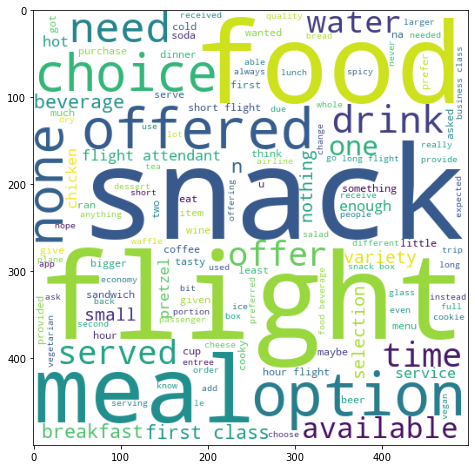

In [52]:
plt.figure(figsize=(20,8))
plt.imshow(pos_wc)

In [48]:
neg_wc = wc.generate(review_df[review_df['sentiment'] == "Negative"]['text'].str.cat(sep=" "))

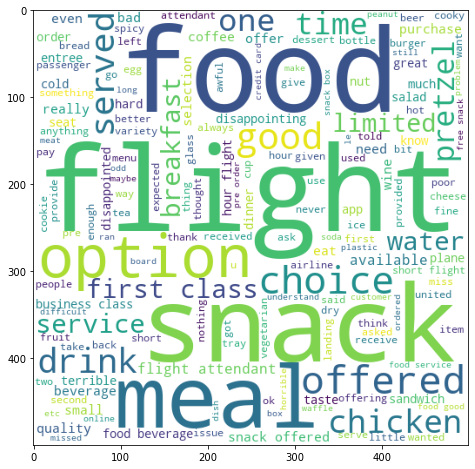

In [49]:
plt.figure(figsize=(20,8))
plt.imshow(neg_wc)

In [50]:
neu_wc = wc.generate(review_df[review_df['sentiment'] == "Neutral"]['text'].str.cat(sep=" "))

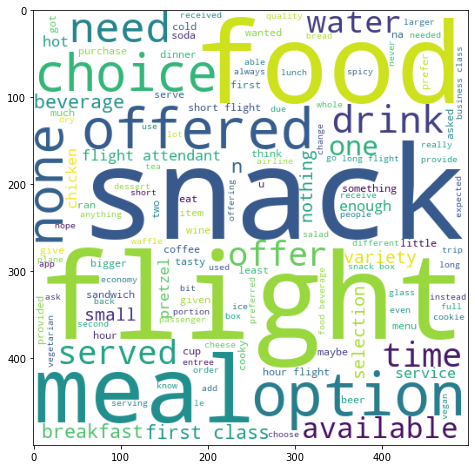

In [51]:
plt.figure(figsize=(20,8))
plt.imshow(neu_wc)

# Topic Modelling

## Postive with trigram

In [53]:
vectorizer3 = CountVectorizer(analyzer = 'word', ngram_range = (3, 3))
print(vectorizer3)
print(vectorizer3.dtype)

# join the processed data to be vectorised
vectors_positive_3 = []

for index, row in review_positive_df.iterrows():
    vectors_positive_3.append(", ".join(row['lemmatise']))

vectorised_positive_3 = vectorizer3.fit_transform(vectors_positive_3)

print(vectorised_positive_3)
print(vectorised_positive_3.dtype)

CountVectorizer(ngram_range=(3, 3))
<class 'numpy.int64'>
  (0, 14470)	1
  (0, 11651)	1
  (0, 21346)	1
  (1, 20529)	1
  (1, 2720)	1
  (2, 13665)	1
  (2, 30748)	1
  (2, 16117)	1
  (2, 29154)	1
  (3, 12234)	1
  (3, 12367)	1
  (3, 21094)	1
  (3, 16215)	1
  (3, 1223)	1
  (3, 21361)	1
  (3, 27875)	1
  (3, 33177)	1
  (3, 19438)	1
  (3, 14115)	1
  (3, 12638)	1
  (3, 12236)	1
  (3, 12395)	1
  (3, 31418)	1
  (3, 519)	1
  (3, 805)	1
  :	:
  (4319, 16118)	1
  (4319, 31831)	1
  (4319, 14867)	1
  (4319, 20321)	1
  (4319, 23084)	1
  (4319, 22333)	1
  (4319, 24173)	1
  (4319, 18650)	1
  (4320, 10329)	1
  (4320, 1678)	1
  (4320, 18694)	1
  (4320, 8289)	1
  (4320, 21387)	1
  (4320, 8835)	1
  (4320, 19227)	1
  (4320, 24442)	1
  (4320, 8308)	1
  (4320, 24707)	1
  (4320, 22756)	1
  (4320, 12766)	1
  (4320, 24208)	1
  (4321, 29198)	1
  (4321, 20425)	1
  (4321, 5727)	1
  (4321, 32695)	1
int64


In [54]:
lda_positive3_output = lda_model.fit_transform(vectorised_positive_3)

In [55]:
keywords3_pos = np.array(vectorizer3.get_feature_names_out())

topic_keywords3_pos = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords3_pos.append(keywords3_pos.take(top_keyword_locs))

for i in topic_keywords3_pos:
    print(i)

['gluten free meal' 'option would great' 'gluten free snack'
 'snack would nice' 'option would nice' 'would nice offered'
 'diet dr pepper' 'please bring back' 'gluten free option'
 'would love see' 'would like able' 'ice cream sundae'
 'offering dr pepper' 'long haul flight' 'cross country flight'
 'vegan option would' 'would like know' 'first class would'
 'nice offered snack' 'chicken dish good' 'would nice get'
 'would nice snack' 'would like see' 'quality could better'
 'snack would great']
['option would nice' 'would like see' 'snack would appreciated'
 'gluten free option' 'turkey cheese sandwich' 'snack would nice'
 'would liked snack' 'option would good' 'free snack would'
 'snack option would' 'snack box available' 'flight attendant gave'
 'food could better' 'better selection snack' 'able pre order'
 'would nice offered' 'hot food option' 'would nice snack'
 'free option would' 'flew first class' 'pretzel would nice'
 'caffeine free diet' 'food much better' 'best meal ever'


## Negative Trigram

In [56]:
vectors_negative_3 = []

for index, row in review_negative_df.iterrows():
    vectors_negative_3.append(", ".join(row['lemmatise']))

vectorised_negative_3 = vectorizer3.fit_transform(vectors_negative_3)

print(vectorised_negative_3)
print(vectorised_negative_3.dtype)

  (0, 9780)	1
  (0, 3233)	1
  (0, 11097)	1
  (0, 5946)	1
  (0, 4449)	1
  (0, 9479)	1
  (0, 9779)	1
  (1, 10370)	1
  (1, 8976)	1
  (1, 2547)	1
  (1, 4042)	1
  (1, 2127)	1
  (1, 3878)	1
  (1, 3135)	1
  (1, 9425)	1
  (1, 6550)	1
  (1, 11601)	1
  (1, 1829)	1
  (1, 12821)	1
  (1, 5257)	1
  (2, 3587)	1
  (2, 5854)	1
  (2, 2277)	1
  (2, 2868)	1
  (2, 5966)	1
  :	:
  (2673, 4145)	1
  (2673, 12501)	1
  (2673, 7694)	1
  (2673, 4432)	1
  (2673, 8811)	1
  (2673, 9837)	1
  (2673, 4908)	1
  (2673, 3082)	1
  (2673, 1073)	1
  (2673, 8129)	1
  (2673, 10050)	1
  (2673, 207)	1
  (2674, 12322)	1
  (2674, 8007)	1
  (2674, 1355)	1
  (2674, 3492)	1
  (2675, 11385)	1
  (2675, 1291)	1
  (2675, 7362)	1
  (2675, 1019)	1
  (2675, 8602)	1
  (2675, 1967)	1
  (2675, 9118)	1
  (2675, 1956)	1
  (2675, 289)	1
int64


In [57]:
lda_negative3_output = lda_model.fit_transform(vectorised_negative_3)

In [58]:
keywords_neg_3 = np.array(vectorizer3.get_feature_names_out())

topic_keywords3_neg = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords3_neg.append(keywords_neg_3.take(top_keyword_locs))

for i in topic_keywords3_neg:
    print(i)

['bloody mary mix' 'service first class' 'even first class'
 'ice cream dessert' 'snack food offered' 'especially business class'
 'take credit card' 'flight business class' 'food served short'
 'beverage food served' 'offered free snack' 'complimentary snack offered'
 'snack first class' 'served short flight' 'food beverage flight'
 'food poor quality' 'snack hour flight' 'wine offered flight'
 'white wine offered' 'business class food' 'single malt scotch'
 'low salt option' 'requested gluten free' 'flying first class'
 'way back snack']
['food beverage service' 'first class food' 'ice cream sundae'
 'asked special meal' 'drink never came' 'flight attendant order'
 'order drink never' 'attendant order drink' 'meat le meatball'
 'beverage service short' 'miss honey roasted' 'honey roasted peanut'
 'breakfast poor yogurt' 'wine quality great' 'short flight beverage'
 'limited selection food' 'service short flight' 'flight snack offered'
 'food beverage offered' 'snack hour flight' 'fli

## Neutral Trigram

In [59]:
vectors_neutral_3 = []

for index, row in review_neutral_df.iterrows():
    vectors_neutral_3.append(", ".join(row['lemmatise']))

vectorised_neutral_3 = vectorizer3.fit_transform(vectors_neutral_3)

print(vectorised_neutral_3)
print(vectorised_neutral_3.dtype)

  (1, 7432)	1
  (2, 3518)	1
  (2, 6136)	1
  (2, 5621)	1
  (4, 1118)	1
  (4, 6027)	1
  (6, 7836)	1
  (6, 5391)	1
  (6, 748)	1
  (6, 7588)	1
  (6, 655)	1
  (6, 1718)	1
  (6, 5820)	1
  (7, 4415)	1
  (8, 7232)	1
  (8, 3141)	1
  (9, 4020)	1
  (9, 3167)	1
  (9, 3557)	1
  (9, 4985)	1
  (9, 4327)	1
  (9, 790)	1
  (9, 1506)	1
  (10, 2854)	1
  (10, 5667)	1
  :	:
  (2419, 6356)	1
  (2419, 2555)	1
  (2419, 3699)	1
  (2419, 6198)	1
  (2422, 6867)	1
  (2422, 3454)	1
  (2422, 1637)	1
  (2422, 298)	1
  (2422, 6952)	1
  (2422, 5019)	1
  (2422, 3595)	1
  (2425, 7759)	1
  (2425, 6520)	1
  (2425, 4330)	1
  (2425, 2009)	1
  (2425, 5094)	1
  (2425, 2781)	1
  (2425, 2062)	1
  (2425, 2826)	1
  (2425, 4922)	1
  (2425, 940)	1
  (2425, 2411)	1
  (2425, 296)	1
  (2425, 3494)	1
  (2425, 3781)	1
int64


In [60]:
lda_neutral3_output = lda_model.fit_transform(vectorised_neutral_3)

In [65]:
keywords_neutral_3 = np.array(vectorizer3.get_feature_names_out())

topic_keywords3_neutral = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords3_neutral.append(keywords_neutral_3.take(top_keyword_locs))

for i in topic_keywords3_neutral:
    print(i)

['diet ginger ale' 'food beverage service' 'bottle water glass'
 'also hour flight' 'business class offering' 'small bottle water'
 'option first class' 'served short flight' 'need dr pepper'
 'variety bigger snack' 'non alcoholic beer' 'food need upgraded'
 'bigger portion snack' 'pre order meal' 'first class snack'
 'able pre order' 'choose meal prior' 'cross country flight'
 'diet mountain dew' 'flight flight attendant' 'asked flight attendant'
 'diet sprite diet' 'pretzel waffle cookie' 'recycle bag back'
 'can glass paper']
['food beverage service' 'first class food' 'long flight meal'
 'business first class' 'first class ticket' 'meal first class'
 'order flight attendant' 'first class meal' 'flight attendant made'
 'meal portion small' 'available flight attendant' 'meal served long'
 'eight hour flight' 'food served hot' 'never came back' 'least one time'
 'short flight nothing' 'food exceeded expectation' 'small snack beverage'
 'ran ginger ale' 'bring back peanut' 'flight atte

# Topic Modelling for 4gram

## Positive

In [75]:
vectorizer4 = CountVectorizer(analyzer = 'word', ngram_range = (4, 4))
print(vectorizer4)
print(vectorizer4.dtype)

# join the processed data to be vectorised
vectors_positive_4 = []

for index, row in review_positive_df.iterrows():
    vectors_positive_4.append(", ".join(row['lemmatise']))

vectorised_positive_4 = vectorizer4.fit_transform(vectors_positive_4)

print(vectorised_positive_4)
print(vectorised_positive_4.dtype)

CountVectorizer(ngram_range=(4, 4))
<class 'numpy.int64'>
  (0, 13524)	1
  (0, 10913)	1
  (1, 19210)	1
  (2, 12791)	1
  (2, 28700)	1
  (2, 15069)	1
  (3, 11464)	1
  (3, 11585)	1
  (3, 19747)	1
  (3, 15164)	1
  (3, 1134)	1
  (3, 20001)	1
  (3, 26050)	1
  (3, 31077)	1
  (3, 18186)	1
  (3, 13202)	1
  (3, 11828)	1
  (3, 11466)	1
  (3, 11607)	1
  (3, 29333)	1
  (3, 478)	1
  (3, 737)	1
  (3, 25198)	1
  (3, 23457)	1
  (3, 17112)	1
  :	:
  (4319, 10859)	1
  (4319, 19472)	1
  (4319, 26946)	1
  (4319, 15070)	1
  (4319, 29701)	1
  (4319, 13920)	1
  (4319, 19011)	1
  (4319, 21603)	1
  (4319, 20870)	1
  (4319, 22602)	1
  (4320, 9624)	1
  (4320, 1557)	1
  (4320, 17467)	1
  (4320, 7694)	1
  (4320, 20027)	1
  (4320, 8191)	1
  (4320, 17986)	1
  (4320, 22850)	1
  (4320, 7711)	1
  (4320, 23087)	1
  (4320, 21283)	1
  (4320, 11940)	1
  (4321, 19109)	1
  (4321, 5337)	1
  (4321, 27260)	1
int64


In [76]:
lda_positive4_output = lda_model.fit_transform(vectorised_positive_4)

In [77]:
keywords4_pos = np.array(vectorizer4.get_feature_names_out())

topic_keywords4_pos = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords4_pos.append(keywords4_pos.take(top_keyword_locs))

for i in topic_keywords4_pos:
    print(i)

['would like see option' 'gluten free option snack'
 'small snack would nice' 'diet dr pepper would' 'hour flight would nice'
 'would nice small snack' 'ahead flight flight attendant'
 'day ahead flight flight' 'like see option available'
 'could little bigger especially' 'snack box would nice'
 'would great could offer' 'potato chip would nice'
 'dr pepper would great' 'would nice get snack' 'need gluten free option'
 'food beverage served flight' 'snack like biscoff pretzel'
 'larger portion would nice' 'snack like nut pretzel'
 'see wanted anything else' 'pre order meal return'
 'order meal return flight' 'asked would like drink'
 'best meal ever airplane']
['would nice gluten free' 'need gluten free option'
 'gluten free snack option' 'would nice offered whole'
 'would nice different option' 'chicken orzo impossible meatball'
 'also different water dasani' 'service would nice get'
 'wine offered even though' 'would nice flight attendant'
 'nice provide small snack' 'would nice prov

## Negative

In [78]:
vectors_negative_4 = []

for index, row in review_negative_df.iterrows():
    vectors_negative_4.append(", ".join(row['lemmatise']))

vectorised_negative_4 = vectorizer4.fit_transform(vectors_negative_4)

print(vectorised_negative_4)
print(vectorised_negative_4.dtype)

  (0, 8855)	1
  (0, 2913)	1
  (0, 10039)	1
  (0, 5413)	1
  (0, 4045)	1
  (0, 8584)	1
  (1, 9385)	1
  (1, 8137)	1
  (1, 2306)	1
  (1, 3636)	1
  (1, 1931)	1
  (1, 3490)	1
  (1, 2824)	1
  (1, 8535)	1
  (1, 5959)	1
  (1, 10488)	1
  (1, 1663)	1
  (1, 11590)	1
  (2, 3236)	1
  (2, 5327)	1
  (2, 2068)	1
  (2, 2586)	1
  (2, 5432)	1
  (2, 7866)	1
  (2, 8620)	1
  :	:
  (2670, 8778)	1
  (2670, 5057)	1
  (2670, 10706)	1
  (2673, 11298)	1
  (2673, 6983)	1
  (2673, 4029)	1
  (2673, 7985)	1
  (2673, 8905)	1
  (2673, 4468)	1
  (2673, 2774)	1
  (2673, 976)	1
  (2673, 7373)	1
  (2673, 9097)	1
  (2673, 3749)	1
  (2674, 11140)	1
  (2674, 7267)	1
  (2674, 1225)	1
  (2675, 10299)	1
  (2675, 1167)	1
  (2675, 6691)	1
  (2675, 928)	1
  (2675, 7795)	1
  (2675, 1786)	1
  (2675, 8263)	1
  (2675, 1777)	1
int64


In [79]:
lda_negative4_output = lda_model.fit_transform(vectorised_negative_4)

In [80]:
keywords_neg_4 = np.array(vectorizer4.get_feature_names_out())

topic_keywords4_neg = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords4_neg.append(keywords_neg_4.take(top_keyword_locs))

for i in topic_keywords4_neg:
    print(i)

['flight sat first class' 'beverage served short flight'
 'food beverage served short' 'food beverage service short'
 'beverage service short flight' 'snack food offered flight'
 'first class food good' 'elect topping many quantity' 'one ua used serve'
 'learning understanding choosing gone' 'also ice cream smoother'
 'region etc unfortunately quality' 'red white ask grape'
 'white ask grape idea' 'selected wine indicating producer'
 'topping many quantity poured' 'quality nice feeling learning'
 'chose sundae sundae nothing' 'ice cream smoother one'
 'feeling learning understanding choosing' 'sundae nothing one ua'
 'sundae sundae nothing one' 'list pre selected wine'
 'nothing one ua used' 'pre selected wine indicating']
['allergic peanut tree nut' 'yo consumo derivados de'
 'veganos etc como yo' 'tal vez un sandwitch'
 'dulce deberia considerar alguna' 'por veganos etc como'
 'alguna alternativa para el' 'sirvieron en el tramo'
 'snack de desayuno fue' 'pan dulce deberia considerar'

## Neutral

In [81]:
vectors_neutral_4 = []

for index, row in review_neutral_df.iterrows():
    vectors_neutral_4.append(", ".join(row['lemmatise']))

vectorised_neutral_4 = vectorizer4.fit_transform(vectors_neutral_4)

print(vectorised_neutral_4)
print(vectorised_neutral_4.dtype)

  (2, 2913)	1
  (2, 5072)	1
  (4, 933)	1
  (6, 6438)	1
  (6, 4469)	1
  (6, 632)	1
  (6, 6239)	1
  (6, 561)	1
  (6, 1422)	1
  (8, 5960)	1
  (9, 3331)	1
  (9, 2628)	1
  (9, 2946)	1
  (9, 4119)	1
  (9, 3592)	1
  (9, 663)	1
  (10, 2373)	1
  (10, 4697)	1
  (10, 4582)	1
  (11, 4862)	1
  (11, 2006)	1
  (11, 275)	1
  (11, 1016)	1
  (11, 1691)	1
  (11, 1247)	1
  :	:
  (2418, 2764)	1
  (2419, 417)	1
  (2419, 4344)	1
  (2419, 5248)	1
  (2419, 2134)	1
  (2419, 3061)	1
  (2422, 5658)	1
  (2422, 2857)	1
  (2422, 1352)	1
  (2422, 260)	1
  (2422, 5726)	1
  (2422, 4150)	1
  (2425, 6372)	1
  (2425, 5382)	1
  (2425, 3595)	1
  (2425, 1658)	1
  (2425, 4220)	1
  (2425, 2313)	1
  (2425, 1703)	1
  (2425, 2348)	1
  (2425, 4072)	1
  (2425, 790)	1
  (2425, 2004)	1
  (2425, 258)	1
  (2425, 2891)	1
int64


In [82]:
lda_neutral4_output = lda_model.fit_transform(vectorised_neutral_4)

In [83]:
keywords_neutral_4 = np.array(vectorizer4.get_feature_names_out())

topic_keywords4_neutral = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords4_neutral.append(keywords_neutral_4.take(top_keyword_locs))

for i in topic_keywords4_neutral:
    print(i)

['flight offered one drink' 'need diet ginger ale'
 'cream chocolate fudge dessert' 'medium warm lh serf'
 'done cold food hot' 'food medium warm lh' 'bad served cracker plastic'
 'lh swiss like salad' 'lh serf main course' 'ua work oh hour'
 'ridiculously bad served cracker' 'business live competition try'
 'together time one done' 'hour issue cheese ridiculously'
 'cracker plastic wrap absurd' 'food hot food medium'
 'issue cheese ridiculously bad' 'dessert entire world goodness'
 'overall food quality business' 'quality business live competition'
 'desert forever presented vanilla' 'competition try lh swiss'
 'vanilla ice cream chocolate' 'chocolate fudge dessert entire'
 'served cracker plastic wrap']
['snack portion size small' 'putting package together yoh'
 'trade show could work' 'trio small package maybe'
 'provided something protein based' 'could work putting package'
 'talk costco putting together' 'cracker box cookie trio'
 'think nutritional snack provided' 'area lot trade

# Topic Modelling for 4gram

## Positive

In [85]:
vectorizer5 = CountVectorizer(analyzer = 'word', ngram_range = (5, 5))
print(vectorizer5)
print(vectorizer5.dtype)

# join the processed data to be vectorised
vectors_positive_5 = []

for index, row in review_positive_df.iterrows():
    vectors_positive_5.append(", ".join(row['lemmatise']))

vectorised_positive_5 = vectorizer5.fit_transform(vectors_positive_5)

print(vectorised_positive_5)
print(vectorised_positive_5.dtype)


CountVectorizer(ngram_range=(5, 5))
<class 'numpy.int64'>
  (0, 12081)	1
  (2, 11450)	1
  (2, 25669)	1
  (3, 10274)	1
  (3, 10385)	1
  (3, 17630)	1
  (3, 13554)	1
  (3, 1036)	1
  (3, 17857)	1
  (3, 23277)	1
  (3, 27819)	1
  (3, 16249)	1
  (3, 11802)	1
  (3, 10596)	1
  (3, 10275)	1
  (3, 10403)	1
  (3, 26245)	1
  (3, 431)	1
  (3, 673)	1
  (3, 22559)	1
  (3, 20994)	1
  (3, 15290)	1
  (3, 28038)	1
  (4, 27606)	1
  (4, 13806)	1
  :	:
  (4319, 23196)	1
  (4319, 13846)	1
  (4319, 23460)	1
  (4319, 9752)	1
  (4319, 17383)	1
  (4319, 24093)	1
  (4319, 13473)	1
  (4319, 26572)	1
  (4319, 12447)	1
  (4319, 16976)	1
  (4319, 19314)	1
  (4319, 18640)	1
  (4320, 8615)	1
  (4320, 1417)	1
  (4320, 15614)	1
  (4320, 6891)	1
  (4320, 17883)	1
  (4320, 7352)	1
  (4320, 16073)	1
  (4320, 20423)	1
  (4320, 6905)	1
  (4320, 20646)	1
  (4320, 19015)	1
  (4321, 17062)	1
  (4321, 4772)	1
int64


In [86]:
lda_positive5_output = lda_model.fit_transform(vectorised_positive_5)

keywords5_pos = np.array(vectorizer5.get_feature_names_out())

topic_keywords5_pos = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords5_pos.append(keywords5_pos.take(top_keyword_locs))

for i in topic_keywords5_pos:
    print(i)

['would like see option available' 'love starting offering dr pepper'
 'would love starting offering dr' 'better snack selection first class'
 'dehydrating many people wish avoid'
 'water unfluoridated neurotoxin filtered reverse'
 'would possible pure water coffee' 'nice spring water possible look'
 'read label discloses ingredient form' 'read thoroughly may help clarify'
 'water salted beverage one read' 'water salted beverage ideally water'
 'thoroughly may help clarify water'
 'health reason may something worthwhile'
 'water possible look quality water' 'realize dasani labelled water given'
 'water option aquafina kirkland crystal'
 'unnecessary salt high fructose corn' 'high fructose corn syrup health'
 'cola dasani claim water label' 'part inflight service would possible'
 'water offered flight idealize many' 'beverage one read label discloses'
 'reason may something worthwhile look'
 'spring water possible look quality']
['gluten free option would nice' 'would nice gluten free s

## Negative

In [87]:
vectors_negative_5 = []

for index, row in review_negative_df.iterrows():
    vectors_negative_5.append(", ".join(row['lemmatise']))

vectorised_negative_5 = vectorizer5.fit_transform(vectors_negative_5)

print(vectorised_negative_5)
print(vectorised_negative_5.dtype)

  (0, 7853)	1
  (0, 2563)	1
  (0, 8887)	1
  (0, 4774)	1
  (0, 3573)	1
  (1, 8329)	1
  (1, 7211)	1
  (1, 2028)	1
  (1, 3211)	1
  (1, 1703)	1
  (1, 3079)	1
  (1, 2485)	1
  (1, 7564)	1
  (1, 5250)	1
  (1, 9292)	1
  (1, 1472)	1
  (2, 2842)	1
  (2, 4695)	1
  (2, 1826)	1
  (2, 2272)	1
  (2, 4791)	1
  (2, 6964)	1
  (3, 9299)	1
  (3, 7523)	1
  (3, 2887)	1
  :	:
  (2661, 1625)	1
  (2661, 3728)	1
  (2661, 1973)	1
  (2670, 2429)	1
  (2670, 7779)	1
  (2670, 4458)	1
  (2673, 10017)	1
  (2673, 6176)	1
  (2673, 3559)	1
  (2673, 7075)	1
  (2673, 7902)	1
  (2673, 3951)	1
  (2673, 2443)	1
  (2673, 863)	1
  (2673, 6519)	1
  (2673, 8073)	1
  (2674, 9882)	1
  (2674, 6428)	1
  (2675, 9118)	1
  (2675, 1028)	1
  (2675, 5907)	1
  (2675, 822)	1
  (2675, 6901)	1
  (2675, 1580)	1
  (2675, 7324)	1
int64


In [88]:
lda_negative5_output = lda_model.fit_transform(vectorised_negative_5)

keywords_neg_5 = np.array(vectorizer5.get_feature_names_out())

topic_keywords5_neg = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords5_neg.append(keywords_neg_4.take(top_keyword_locs))

for i in topic_keywords5_neg:
    print(i)

['atop waffle usually soggy' 'even salt pepper added'
 'option time flight nothing' 'limited selection snack sugary'
 'see screenshot call customer' 'consumer opposed simply stating'
 'disappointing alternative yogurt hard'
 'disappointing also plenty beverage' 'either bring pay high'
 'link return flight never' 'box need better pita'
 'glass turbulence impossible cut' 'phone airplane mode would'
 'glass wine first class' 'breakfast egg chicken sausage'
 'say curry chicken meal' 'provided breakfast still green'
 'gluten free food online' 'provided flight provide water'
 'breakfast snack yoghurt biscotti' 'breakfast still green banana'
 'snack food purchase seem' 'gluten free option complimentary'
 'food except pretzel cracker' 'food economy even know']
['first took flight attendant' 'good good main meal'
 'available last alternative something' 'louisville flight sat first'
 'snack biscuit pretzel etc' 'stating pre order mistake'
 'filled small amount crushed' 'first board bad procedure

## Neutral


In [91]:
vectors_neutral_5 = []

for index, row in review_neutral_df.iterrows():
    vectors_neutral_5.append(", ".join(row['lemmatise']))

vectorised_neutral_5 = vectorizer5.fit_transform(vectors_neutral_5)

print(vectorised_neutral_5)
print(vectorised_neutral_5.dtype)

  (2, 2331)	1
  (6, 5152)	1
  (6, 3569)	1
  (6, 514)	1
  (6, 4990)	1
  (6, 460)	1
  (9, 2662)	1
  (9, 2103)	1
  (9, 2357)	1
  (9, 3274)	1
  (9, 2865)	1
  (10, 1901)	1
  (10, 3740)	1
  (11, 3874)	1
  (11, 1605)	1
  (11, 227)	1
  (11, 805)	1
  (11, 1352)	1
  (11, 994)	1
  (11, 3630)	1
  (12, 3798)	1
  (12, 4190)	1
  (13, 1766)	1
  (13, 3762)	1
  (13, 1001)	1
  :	:
  (2416, 3048)	1
  (2416, 1179)	1
  (2418, 132)	1
  (2418, 2140)	1
  (2419, 343)	1
  (2419, 3458)	1
  (2419, 4194)	1
  (2419, 1717)	1
  (2422, 4512)	1
  (2422, 2285)	1
  (2422, 1077)	1
  (2422, 216)	1
  (2422, 4567)	1
  (2425, 5095)	1
  (2425, 4300)	1
  (2425, 2867)	1
  (2425, 1325)	1
  (2425, 3359)	1
  (2425, 1848)	1
  (2425, 1362)	1
  (2425, 1880)	1
  (2425, 3236)	1
  (2425, 639)	1
  (2425, 1604)	1
  (2425, 214)	1
int64


In [92]:
lda_neutral5_output = lda_model.fit_transform(vectorised_neutral_5)

keywords_neutral_5 = np.array(vectorizer5.get_feature_names_out())

topic_keywords5_neutral = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords5_neutral.append(keywords_neutral_5.take(top_keyword_locs))

for i in topic_keywords5_neutral:
    print(i)

['service deteriorated especially covid example'
 'meal wine etc choice meal' 'wife flew business class general'
 'pay little better meal although'
 'although think considering cost business'
 'etc choice meal service somewhere'
 'meal service somewhere inbetween coach' 'willing pay little better meal'
 'case flight used sundae cart'
 'meal service deteriorated especially covid'
 'drink case flight used sundae' 'least got back pre covid'
 'would even willing pay little'
 'class meal service deteriorated especially'
 'even willing pay little better' 'class general quality business class'
 'better meal although think considering' 'also menu go meal wine'
 'wine etc choice meal service' 'pre covid environment would even'
 'service somewhere inbetween coach business'
 'flight used sundae cart brought' 'inbetween coach business would nice'
 'typically served nut first drink'
 'think considering cost business class']
['almost receive first choice heard' 'available seems snack box choice'
 'c